# 2017年度の法政大学栄養ドリンクの解法をGBDTでやってみる(同じ結果になるのか?)

In [2]:
import os
import pandas as pd
import numpy as np
#import dask.dataframe as dd   #データの読み込みを高速化、今回はrow数が足りなくて実行できない?
import time

import matplotlib.pyplot as plt
%matplotlib inline
import japanize_matplotlib
import seaborn as sns
sns.set(font='IPAexGothic')
import lightgbm as lgbm
from lightgbm import *
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

pd.set_option('display.max_columns',30)

In [3]:
DATA_DIR = '../Data'
CSV_DIR = os.path.join(DATA_DIR,'CSV')
MONTH_2_3_DIR = os.path.join(CSV_DIR,'02-03月調査')
MONTH_9_10_DIR = os.path.join(CSV_DIR,'09-10月調査')

In [4]:
# =======================================================
# データロード
# 今回は2021年度2,3月データを使用(理由は特になし)
# =======================================================

customer_df = pd.read_csv(os.path.join(MONTH_2_3_DIR,'属性データ_02-03月.csv')) #2,3月顧客情報
process_df = pd.read_csv(os.path.join(MONTH_2_3_DIR,'購買プロセス_02-03月.csv')) #2,3月購買プロセス
display(customer_df.head())
display(process_df.head())

,SampleID,SEX_CD,AGE,MARRIAGE,FAMILY_CD,CHILD_CD_NEW,CHILD_AGE_1,CHILD_AGE_2,CHILD_AGE_3,CHILD_AGE_4,CHILD_AGE_5,PREF_CD,JOB_CD,HOME_CD,BS視聴_CD,...,MZ.2650306,MZ.1820312,MZ.2440146,MZ.0210074,MZ.2620074,MZ.1720142,MZ.1230155,MZ.2670276,MZ.2140300,MZ.2730297,MZ.2770295,MZ.2760295,MZ.2780297,MZ.2720296,MZ.2710295
0,1160001,1,48,1,3,5,,,,,,11,8,2,2,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,1160002,1,51,2,2,,,,,,,13,8,5,1,...,0,0,0,0,0,0,0,0,0,1,0,1,1,0,1
2,1160003,2,55,2,3,1,25,,,,,13,1,2,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1160004,1,60,2,3,3,29,27,22,,,10,2,2,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1160005,1,39,2,3,2,14,12,,,,13,8,3,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


,SampleID,PS_01_B00004096,PI_01_B00004096,PS_02_B00004096,PI_02_B00004096,F_TV1_B00004096,PS_01_B00004097,PI_01_B00004097,PS_02_B00004097,PI_02_B00004097,F_TV1_B00004097,PS_01_B00004098,PI_01_B00004098,PS_02_B00004098,PI_02_B00004098,...,PS_01_B00003408,PI_01_B00003408,PS_02_B00003408,PI_02_B00003408,F_TV1_B00003408,PS_01_B00003419,PI_01_B00003419,PS_02_B00003419,PI_02_B00003419,F_TV1_B00003419,PS_01_B00003420,PI_01_B00003420,PS_02_B00003420,PI_02_B00003420,F_TV1_B00003420
0,1160001,3,3,2,3,,4,3,3,3,,3,3,3,3,...,4,3,3,3,,4,3,3,2,,4,3,4,3,2
1,1160002,2,3,2,2,,3,4,2,3,,2,3,2,4,...,4,3,3,4,,3,2,3,4,,4,3,4,4,10
2,1160003,3,3,3,3,,4,3,4,3,,3,4,3,4,...,4,3,3,3,,3,2,3,2,,3,2,3,3,0
3,1160004,4,3,4,3,,4,3,4,3,,2,3,4,3,...,4,2,4,1,,4,2,4,2,,4,2,4,2,0
4,1160005,1,2,2,2,,2,4,3,4,,2,3,3,4,...,3,2,3,1,,2,1,3,1,,3,2,4,2,10


In [5]:
customer_df.shape

(2981, 1952)

In [10]:
# ===================================================
#　データ加工
#　1つでも欠損があるデータは削除
# ===================================================

# CGM
CGM_df = customer_df[["SampleID","W02_Q026B001_001_MX","W02_Q026B001_002_MX","W02_Q026B001_003_MX","W02_Q026B001_005_MX"]]
CGM_df.columns = ["ID","Twitter","Facebook","Instagram","LINE"]
CGM_df.replace(" ",-1,inplace=True)
CGM_df.dropna(how="any",axis=0,inplace=True)
CGM_df = CGM_df.astype("str")
CGM_df = CGM_df.astype(int)
CGM_df = CGM_df[(CGM_df.Twitter>-1) & (CGM_df.Facebook>-1) & (CGM_df.Instagram>-1) & (CGM_df.LINE>-1)]

freq_CGM = [1,2,3,4]
CGM_df["CGM_Twitter"] = 0
CGM_df.loc[(CGM_df["Twitter"].isin(freq_CGM)),"CGM_Twitter"] = 1

CGM_df["CGM_Facebook"] = 0
CGM_df.loc[(CGM_df.Facebook.isin(freq_CGM)),"CGM_Facebook"] = 1

CGM_df["CGM_Instagram"] = 0
CGM_df.loc[(CGM_df.Instagram.isin(freq_CGM)),"CGM_Instagram"] = 1

CGM_df["CGM_LINE"] = 0
CGM_df.loc[(CGM_df.LINE.isin(freq_CGM)),"CGM_LINE"] = 1


#趣味
Hobby_df = customer_df[["SampleID","W04_Q035B001_001_MA","W04_Q035B001_002_MA","W04_Q035B001_003_MA","W04_Q035B001_004_MA","W04_Q035B001_005_MA"]]
Hobby_df.columns = ["ID","スポーツ、フィットネス","ゴルフ","スキー、スノボ","釣り","アウトドア、キャンプ"]
Hobby_df.replace(" ",-1,inplace=True)
Hobby_df.dropna(how="any",axis=0,inplace=True)
Hobby_df = Hobby_df.astype("str")
Hobby_df = Hobby_df.astype(int)
Hobby_df = Hobby_df[(Hobby_df["スポーツ、フィットネス"]>-1) & (Hobby_df["ゴルフ"]>-1) &
                 (Hobby_df["スキー、スノボ"]>-1) & (Hobby_df["釣り"]>-1) & (Hobby_df["アウトドア、キャンプ"]>-1)]
Hobby_df["HobbyCount"] = Hobby_df.loc[:,"スポーツ、フィットネス":"アウトドア、キャンプ"].sum(axis=1)
Hobby_df["Hobbyflag"] = Hobby_df.HobbyCount.apply(lambda x : 1 if x > 0 else x)


#情報
info_df = customer_df[["SampleID","W03_Q049B001_005_MA","W03_Q049B001_010_MA","W03_Q049B001_011_MA","W03_Q049B001_012_MA","W03_Q049B001_014_MA",
                      "W03_Q049B001_030_MA","W03_Q049B001_031_MA"]]
info_df = info_df.rename(columns={"SampleID":"ID"})
info_df.replace(" ",-1,inplace=True)
info_df.dropna(how="any",axis=0,inplace=True)
info_df = info_df.astype("str")
info_df = info_df.astype(int)
info_df = info_df[(info_df["W03_Q049B001_005_MA"]>-1) & (info_df["W03_Q049B001_010_MA"]>-1) & (info_df["W03_Q049B001_011_MA"]>-1) &
                 (info_df["W03_Q049B001_012_MA"]>-1) & (info_df["W03_Q049B001_014_MA"]>-1) & (info_df["W03_Q049B001_030_MA"]>-1) &
                 (info_df["W03_Q049B001_031_MA"]>-1)]
#05,14は0,1反転   いいやり方あったら誰か教えてください
info_df["W03_Q049B001_005_MA"] = info_df["W03_Q049B001_005_MA"].apply(lambda x : -1 if x == 1 else x)
info_df["W03_Q049B001_005_MA"] = info_df["W03_Q049B001_005_MA"].apply(lambda x : 1 if x == 0 else x)
info_df["W03_Q049B001_005_MA"] = info_df["W03_Q049B001_005_MA"].apply(lambda x : 0 if x == -1 else x)

info_df["W03_Q049B001_014_MA"] = info_df["W03_Q049B001_014_MA"].apply(lambda x : -1 if x == 1 else x)
info_df["W03_Q049B001_014_MA"] = info_df["W03_Q049B001_014_MA"].apply(lambda x : 1 if x == 0 else x)
info_df["W03_Q049B001_014_MA"] = info_df["W03_Q049B001_014_MA"].apply(lambda x : 0 if x == -1 else x)

info_df["infoCount"] = info_df.loc[:,"W03_Q049B001_005_MA":"W03_Q049B001_031_MA"].sum(axis=1)
info_df["Infoflag"] = info_df.infoCount.apply(lambda x : 1 if x > 2 else 0)


#目的変数
#アリナミンV・チオビタドリンクはぱっと見なさげ？
target_df = process_df[["SampleID","PS_01_B00001264","PS_01_B00001270","PS_01_B00001278","PS_01_B00001279",
                        "PI_01_B00001264","PI_01_B00001270","PI_01_B00001278","PI_01_B00001279"]]
target_df.columns = ["ID","オルナミンC_実態","タフマン_実態","リポビタンD_実態","レッドブル_実態",
                     "オルナミンC_意向","タフマン_意向","リポビタンD_意向","レッドブル_意向"]
target_df.replace(" ",-1,inplace=True)
target_df.dropna(how="any",axis=0,inplace=True)
target_df = target_df.astype("str")
target_df = target_df.astype(int)
target_df = target_df[(target_df["オルナミンC_実態"]>-1) & (target_df["タフマン_実態"]>-1) &
                      (target_df["リポビタンD_実態"]>-1) & (target_df["レッドブル_実態"]>-1) &
                     (target_df["オルナミンC_意向"]>-1) & (target_df["タフマン_意向"]>-1) &
                      (target_df["リポビタンD_意向"]>-1) & (target_df["レッドブル_意向"]>-1)]
target_df["オルナミンC_認知"] = target_df["オルナミンC_実態"].apply(lambda x : 0 if x == 5 else 1)
target_df["タフマン_認知"] = target_df["タフマン_実態"].apply(lambda x : 0 if x == 5 else 1)
target_df["リポビタンD_認知"] = target_df["リポビタンD_実態"].apply(lambda x : 0 if x == 5 else 1)
target_df["レッドブル_認知"] = target_df["レッドブル_実態"].apply(lambda x : 0 if x == 5 else 1)

target_df["オルナミンC_購買"] = target_df["オルナミンC_実態"].apply(lambda x : 1 if ((x == 1) | (x == 2)) else 0)
target_df["タフマン_購買"] = target_df["タフマン_実態"].apply(lambda x : 1 if ((x == 1) | (x == 2)) else 0)
target_df["リポビタンD_購買"] = target_df["リポビタンD_実態"].apply(lambda x : 1 if ((x == 1) | (x == 2)) else 0)
target_df["レッドブル_購買"] = target_df["レッドブル_実態"].apply(lambda x : 1 if ((x == 1) | (x == 2)) else 0)

target_df["オルナミンC_意向"] = target_df["オルナミンC_意向"].apply(lambda x : 1 if ((x == 1) | (x == 2)) else 0)
target_df["タフマン_意向"] = target_df["タフマン_意向"].apply(lambda x : 1 if ((x == 1) | (x == 2)) else 0)
target_df["リポビタンD_意向"] = target_df["リポビタンD_意向"].apply(lambda x : 1 if ((x == 1) | (x == 2)) else 0)
target_df["レッドブル_意向"] = target_df["レッドブル_意向"].apply(lambda x : 1 if ((x == 1) | (x == 2)) else 0)

target_df.drop(["オルナミンC_実態","タフマン_実態","リポビタンD_実態","レッドブル_実態"],axis=1,inplace=True)


#データフレーム作成
df = customer_df[["SampleID","SEX_CD","AGE","W04_Q036B001_002_MA","W04_Q036B001_009_MA","W04_Q036B001_016_MA",
                 "W04_Q036B001_020_MA","W04_Q036B001_021_MA"]]
df.columns = ["ID","性別","年齢","目の疲れ、かすみ目","筋肉痛、筋肉疲労","ストレス","風邪をひきやすい","疲れやすい"]
df.replace(" ",-1,inplace=True)
df.dropna(how="any",axis=0,inplace=True)
df = df.astype("str")
df = df.astype(int)
df = df[(df["性別"]>-1) & (df["目の疲れ、かすみ目"]>-1) & (df["筋肉痛、筋肉疲労"]>-1) & (df["ストレス"]>-1) & (df["年齢"]>-1) & 
        (df["風邪をひきやすい"]>-1) & (df["疲れやすい"]>-1)]
df["20代"] = df["年齢"].apply(lambda x : 1 if ((x >= 20) & (x < 30)) else 0)
df["30代"] = df["年齢"].apply(lambda x : 1 if ((x >= 30) & (x < 40)) else 0)
df["40代"] = df["年齢"].apply(lambda x : 1 if ((x >= 40) & (x < 50)) else 0)
#20代から40代に限定
#df = df[(df["年齢"]>=20) & (df["年齢"]<50)]
df.drop("年齢",axis=1,inplace=True)

# マージ
df = df.merge(CGM_df[["ID","CGM_Twitter","CGM_Facebook","CGM_Instagram","CGM_LINE"]],how="left",on="ID").merge(Hobby_df[["ID","Hobbyflag"]],how="left",on="ID").merge(info_df[["ID","Infoflag"]],how="left",on="ID").merge(target_df,how="left",on="ID")
df.dropna(how="any",axis=0,inplace=True)
df = df.reset_index(drop=True)
df

c:\Users\mtsuk\anaconda3\lib\site-packages\pandas\core\frame.py:4524: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(
<ipython-input-10-0dfa694c74b5>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CGM_df.dropna(how="any",axis=0,inplace=True)
c:\Users\mtsuk\anaconda3\lib\site-packages\pandas\core\frame.py:4524: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(
<ipython-input-10-0dfa694c74b5>:

,ID,性別,目の疲れ、かすみ目,筋肉痛、筋肉疲労,ストレス,風邪をひきやすい,疲れやすい,20代,30代,40代,CGM_Twitter,CGM_Facebook,CGM_Instagram,CGM_LINE,Hobbyflag,Infoflag,オルナミンC_意向,タフマン_意向,リポビタンD_意向,レッドブル_意向,オルナミンC_認知,タフマン_認知,リポビタンD_認知,レッドブル_認知,オルナミンC_購買,タフマン_購買,リポビタンD_購買,レッドブル_購買
0,1160001,1,0,1,1,0,1,0,0,1,0.0,0.0,0.0,1.0,1,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
1,1160002,1,0,0,1,0,0,0,0,0,0.0,0.0,0.0,1.0,0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
2,1160004,1,0,0,0,0,0,0,0,0,0.0,1.0,0.0,1.0,0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
3,1160005,1,1,0,0,0,1,0,1,0,1.0,0.0,0.0,1.0,0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
4,1160006,1,0,0,0,0,0,0,0,0,1.0,1.0,1.0,1.0,0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2827,1163977,1,0,0,0,0,1,1,0,0,1.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
2828,1163978,2,0,0,0,0,1,0,0,0,1.0,0.0,1.0,1.0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
2829,1163980,1,0,0,0,0,0,1,0,0,0.0,1.0,1.0,1.0,1,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0
2830,1163981,2,1,0,0,0,0,1,0,0,0.0,0.0,1.0,1.0,0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


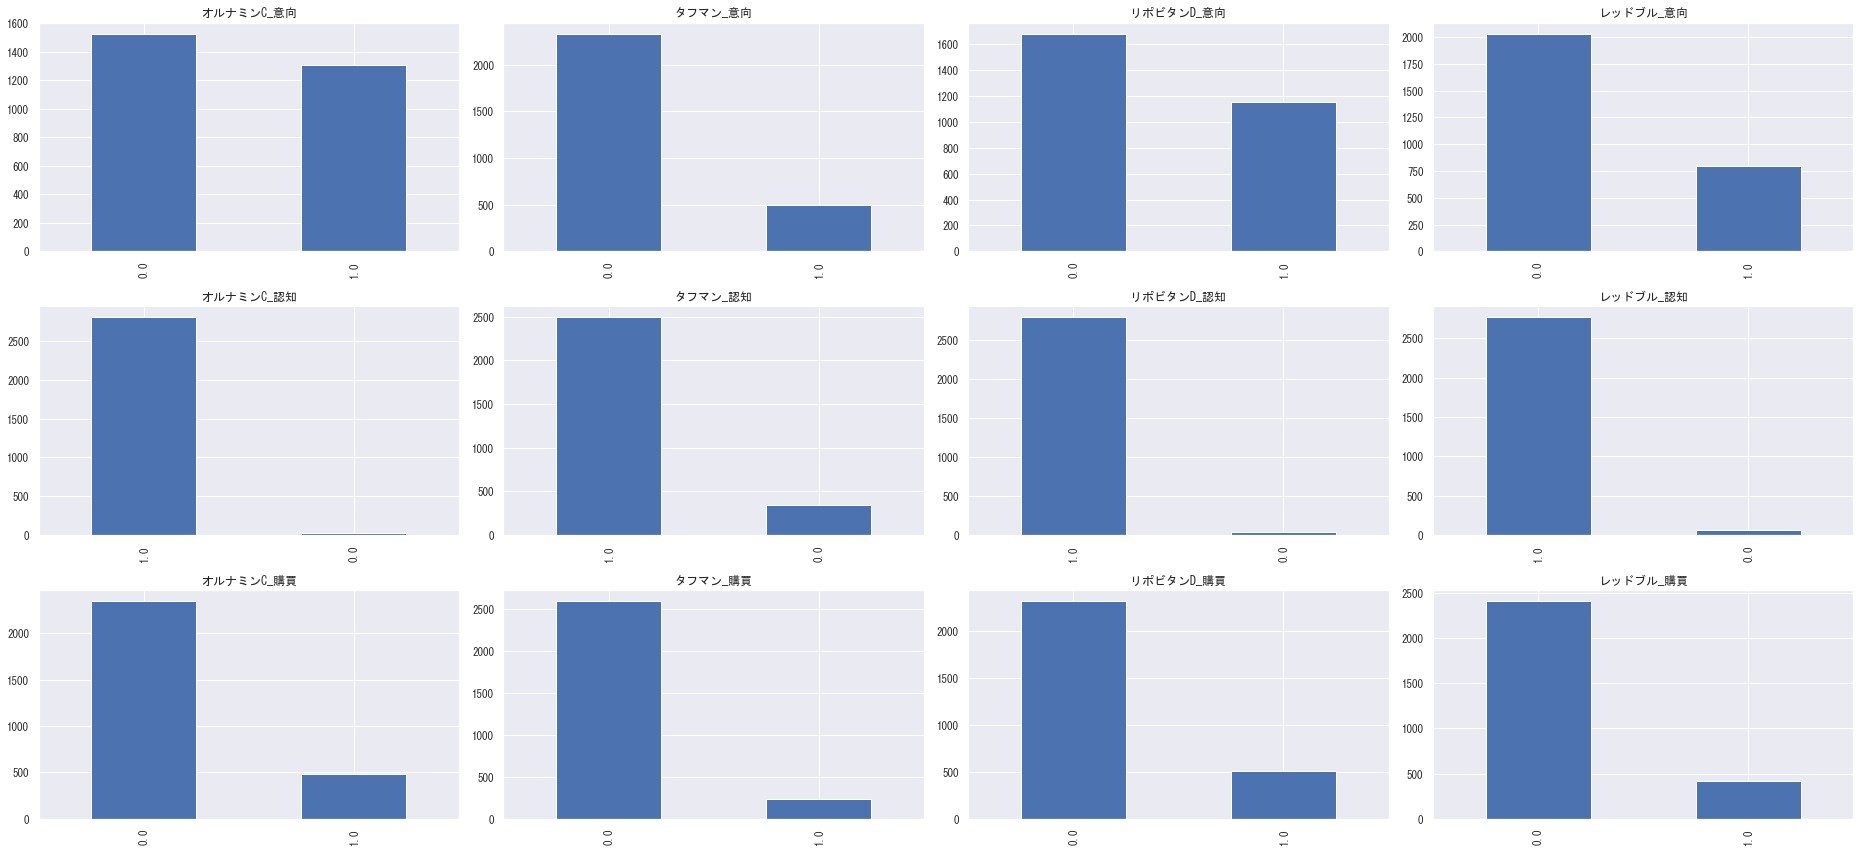

In [11]:
# =============================================================================
# EDA（気持ち程度）そんなに詳しくはやらない、詳しいやつは先生のPNGフォルダ参照
# =============================================================================


#目的変数
#targetに分布差がかなりありそう

target_cols_df = df.loc[:,"オルナミンC_意向":"レッドブル_購買"]
target_cols = target_cols_df.columns
del target_cols_df
nr_rows = 3
nr_cols = 4

plt.rcParams['font.family'] = "MS Gothic"
fig, axs = plt.subplots(nr_rows,nr_cols,figsize=(nr_cols*6.5,nr_rows*4))

for r in range(0,nr_rows):
    for c in range(0,nr_cols):
        i = r*nr_cols + c
        if i < len(target_cols):
            col = target_cols[i]
            df[col].value_counts().plot(kind='bar',title=f"{col}",ax=axs[r][c])
            
plt.tight_layout()
plt.show()

del target_cols

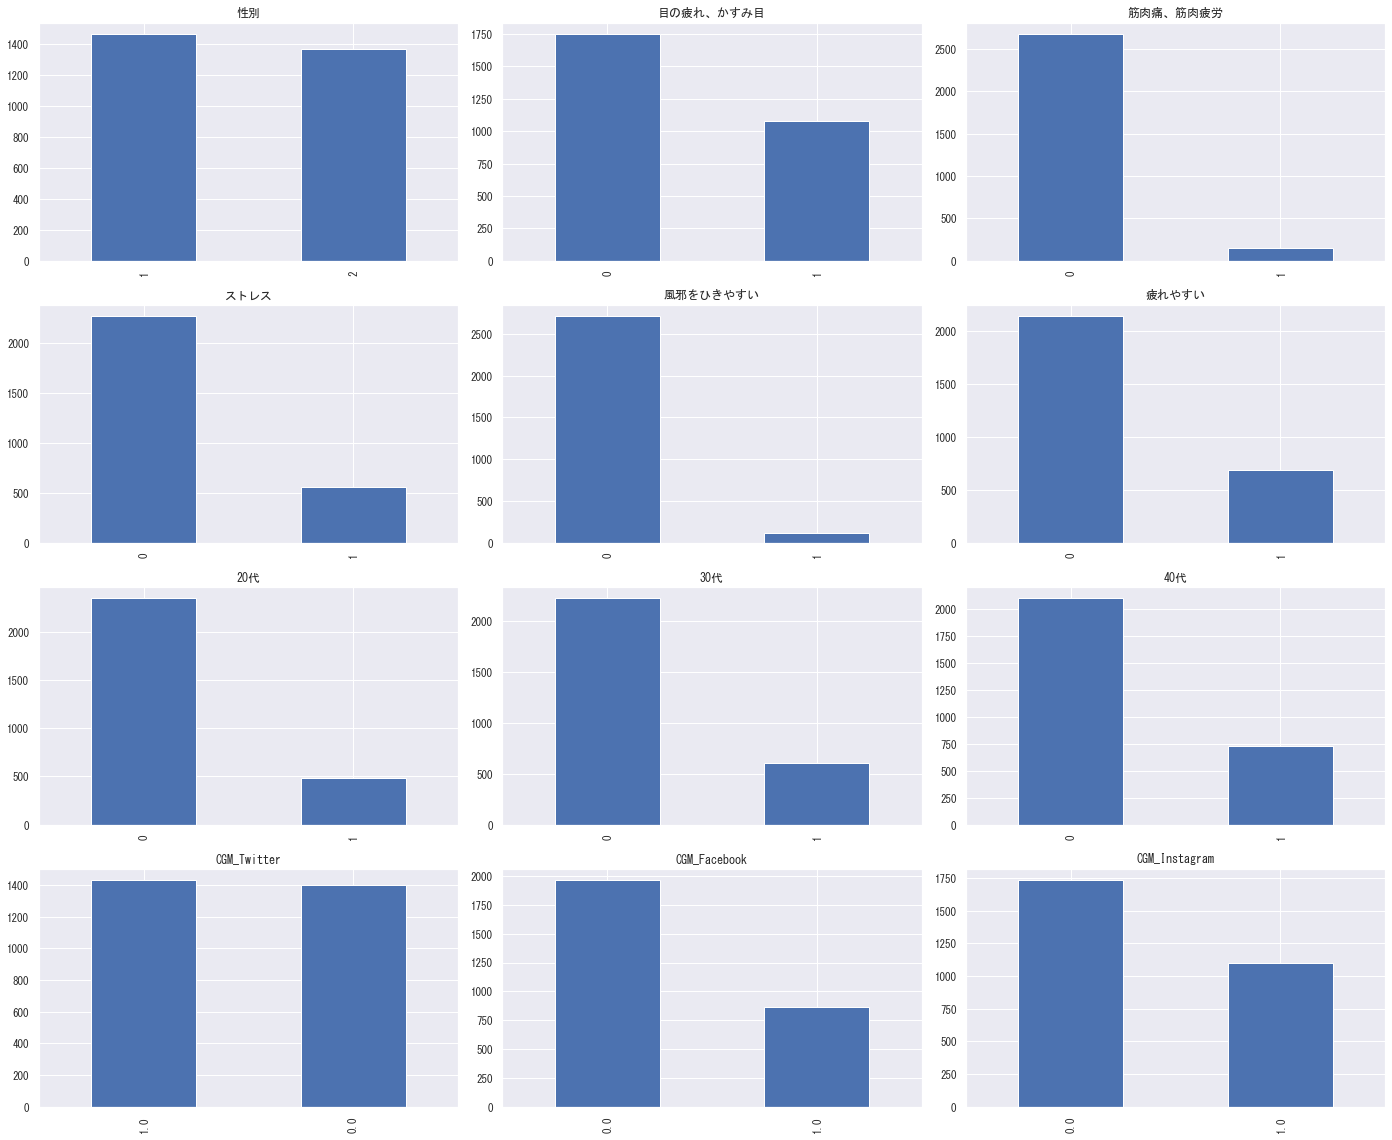

In [12]:
#説明変数

cols_df = df.loc[:,"性別":"Infoflag"]
cols = cols_df.columns
del cols_df
nr_rows = 4
nr_cols = 3

plt.rcParams['font.family'] = "MS Gothic"
fig, axs = plt.subplots(nr_rows,nr_cols,figsize=(nr_cols*6.5,nr_rows*4))

for r in range(0,nr_rows):
    for c in range(0,nr_cols):
        i = r*nr_cols + c
        if i < len(cols):
            col = cols[i]
            df[col].value_counts().plot(kind='bar',title=f"{col}",ax=axs[r][c])

plt.tight_layout()
plt.show()

del cols

In [14]:
# ===============================================================
# LGBMで分析①をやってみる
# LGBMのFeatureImportanceはgain
# ===============================================================

cols = ['性別', '目の疲れ、かすみ目', '筋肉痛、筋肉疲労', 'ストレス', '風邪をひきやすい', '疲れやすい', '20代',
       '30代', '40代', 'CGM_Twitter', 'CGM_Facebook', 'CGM_Instagram',
       'CGM_LINE', 'Hobbyflag', 'Infoflag']
    
def get_importance(df,target,target_name):
    params = {
        "objective" : "binary",
        "metric" : "binary_error",
        "random_state" : 2021
    }
    
    scores = []
    importances = pd.DataFrame()
    skf =StratifiedKFold(n_splits = 5)
    print(f"========== {target_name} ===============")
    for fold ,(tr_idx,va_idx) in enumerate(skf.split(df,target)):
        print(f"========== fold : {fold+1} ===============")
        x_train,x_val = df.iloc[tr_idx],df.iloc[va_idx]
        y_train,y_val = target[tr_idx],target[va_idx]
        
        model = lgbm.LGBMClassifier(**params)
        model.fit(x_train,y_train,
                 eval_set=[(x_val,y_val)],
                 verbose=False)
        val_pred = model.predict(x_val)
        score = accuracy_score(y_val,val_pred)
        print(f"Score : {score}")
        scores.append(score)
        
        fi_tmp = pd.DataFrame()
        fi_tmp["feature"] = df.columns
        fi_tmp["importance"] = model.feature_importances_
        fi_tmp["fold"] = fold
        importances = importances.append(fi_tmp)
        
        del model,x_train,y_train,x_val,y_val
        print("\n")
        
    print(f"Mean Score : {np.mean(scores)}")
    
    sns.set(font='IPAexGothic')
    order = list(importances.groupby("feature").mean().sort_values("importance",ascending=False).index)
    fig = plt.figure(figsize=(12,8),tight_layout=True)
    sns.barplot(x="importance",y="feature",data=importances.groupby("feature").mean().reset_index(),order=order)
    plt.title(f"{target_name} feature importances")

========== オルナミンC_意向 ===============
========== fold : 1 ===============
Score : 0.5502645502645502


========== fold : 2 ===============
Score : 0.6084656084656085


========== fold : 3 ===============
Score : 0.6024734982332155


========== fold : 4 ===============
Score : 0.549469964664311


========== fold : 5 ===============
Score : 0.6007067137809188


Mean Score : 0.5822760670817206


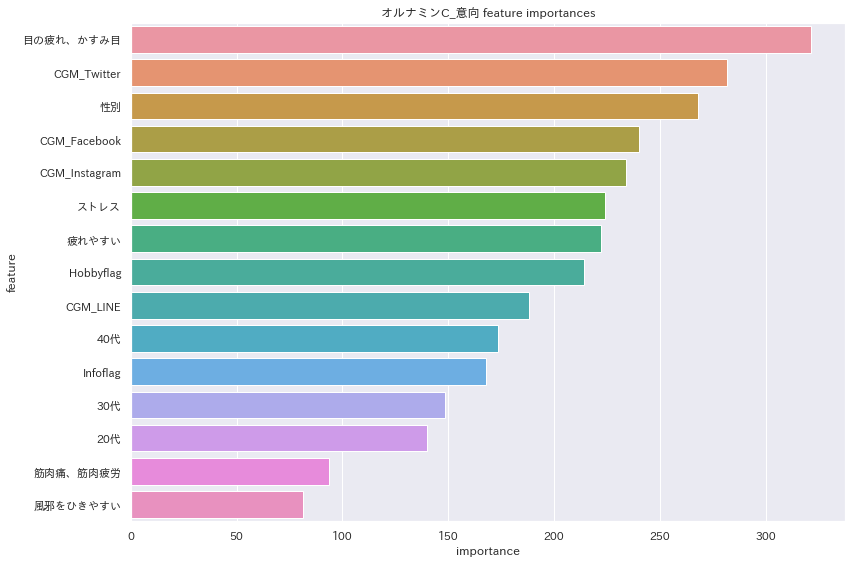

In [15]:
target = "オルナミンC_意向"
df_tmp = df[cols]
target_y = df[target]
get_importance(df_tmp,target_y,target)
del target,df_tmp,target_y

========== タフマン_意向 ===============
========== fold : 1 ===============
Score : 0.800705467372134


========== fold : 2 ===============
Score : 0.8112874779541446


========== fold : 3 ===============
Score : 0.8091872791519434


========== fold : 4 ===============
Score : 0.8162544169611308


========== fold : 5 ===============
Score : 0.803886925795053


Mean Score : 0.8082643134468812


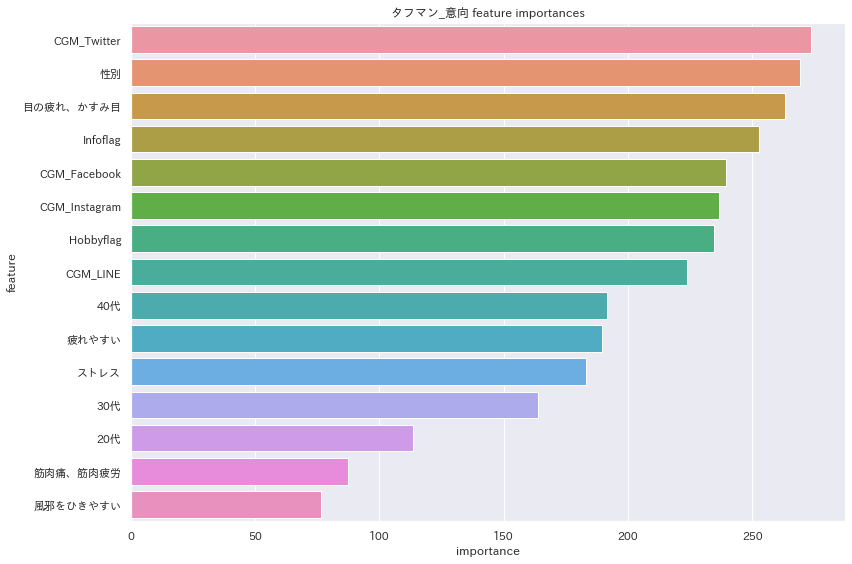

In [16]:
target = "タフマン_意向"
df_tmp = df[cols]
target_y = df[target]
get_importance(df_tmp,target_y,target)
del target,df_tmp,target_y

========== リポビタンD_意向 ===============
========== fold : 1 ===============
Score : 0.6049382716049383


========== fold : 2 ===============
Score : 0.5855379188712522


========== fold : 3 ===============
Score : 0.6113074204946997


========== fold : 4 ===============
Score : 0.6289752650176679


========== fold : 5 ===============
Score : 0.6113074204946997


Mean Score : 0.6084132592966516


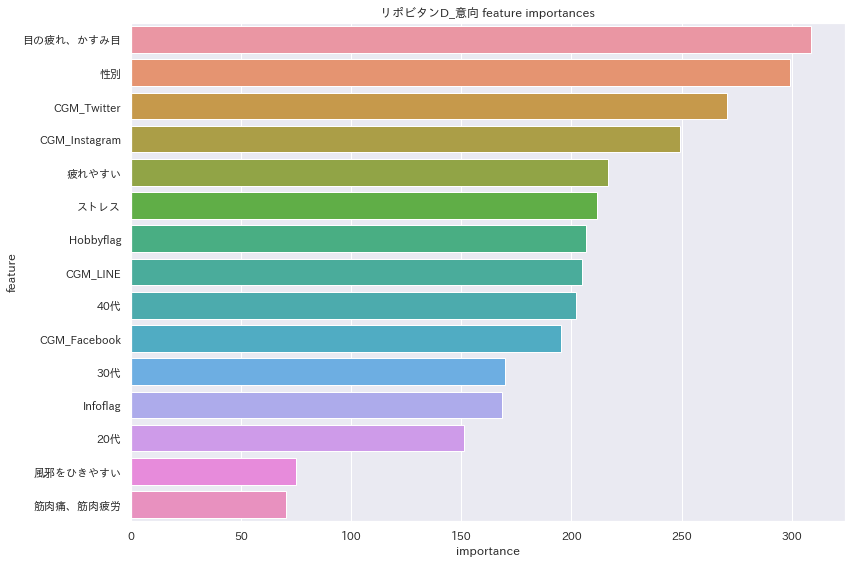

In [17]:
target = "リポビタンD_意向"
df_tmp = df[cols]
target_y = df[target]
get_importance(df_tmp,target_y,target)
del target,df_tmp,target_y

========== レッドブル_意向 ===============
========== fold : 1 ===============
Score : 0.7142857142857143


========== fold : 2 ===============
Score : 0.7213403880070547


========== fold : 3 ===============
Score : 0.7102473498233216


========== fold : 4 ===============
Score : 0.7049469964664311


========== fold : 5 ===============
Score : 0.7243816254416962


Mean Score : 0.7150404148048436


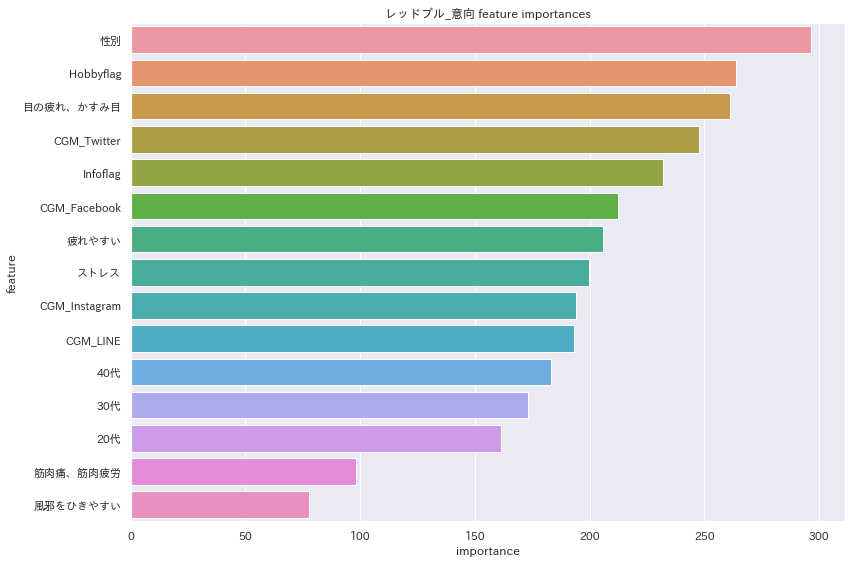

In [18]:
target = "レッドブル_意向"
df_tmp = df[cols]
target_y = df[target]
get_importance(df_tmp,target_y,target)
del target,df_tmp,target_y

========== オルナミンC_認知 ===============
========== fold : 1 ===============
Score : 0.9894179894179894


========== fold : 2 ===============
Score : 0.9876543209876543


========== fold : 3 ===============
Score : 0.9876325088339223


========== fold : 4 ===============
Score : 0.9858657243816255


========== fold : 5 ===============
Score : 0.9893992932862191


Mean Score : 0.9879939673814822


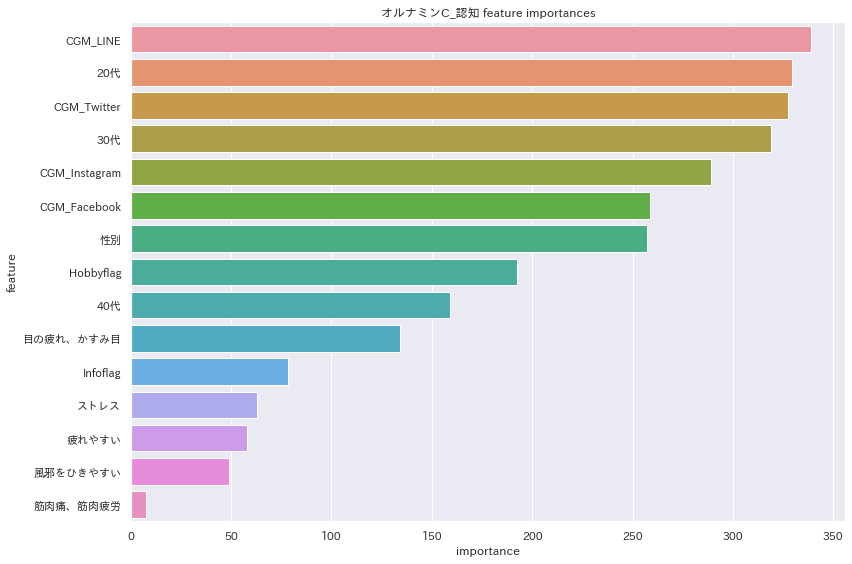

In [19]:
target = "オルナミンC_認知"
df_tmp = df[cols]
target_y = df[target]
get_importance(df_tmp,target_y,target)
del target,df_tmp,target_y

========== タフマン_認知 ===============
========== fold : 1 ===============
Score : 0.8800705467372134


========== fold : 2 ===============
Score : 0.8606701940035273


========== fold : 3 ===============
Score : 0.872791519434629


========== fold : 4 ===============
Score : 0.8745583038869258


========== fold : 5 ===============
Score : 0.8604240282685512


Mean Score : 0.8697029184661693


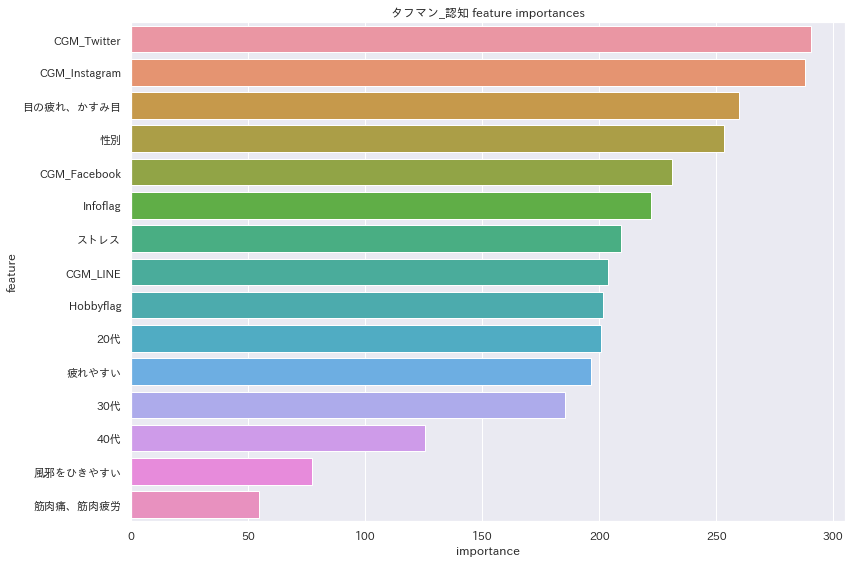

In [20]:
target = "タフマン_認知"
df_tmp = df[cols]
target_y = df[target]
get_importance(df_tmp,target_y,target)
del target,df_tmp,target_y

========== リポビタンD_認知 ===============
========== fold : 1 ===============
Score : 0.9858906525573192


========== fold : 2 ===============
Score : 0.982363315696649


========== fold : 3 ===============
Score : 0.9840989399293286


========== fold : 4 ===============
Score : 0.9858657243816255


========== fold : 5 ===============
Score : 0.9840989399293286


Mean Score : 0.9844635144988502


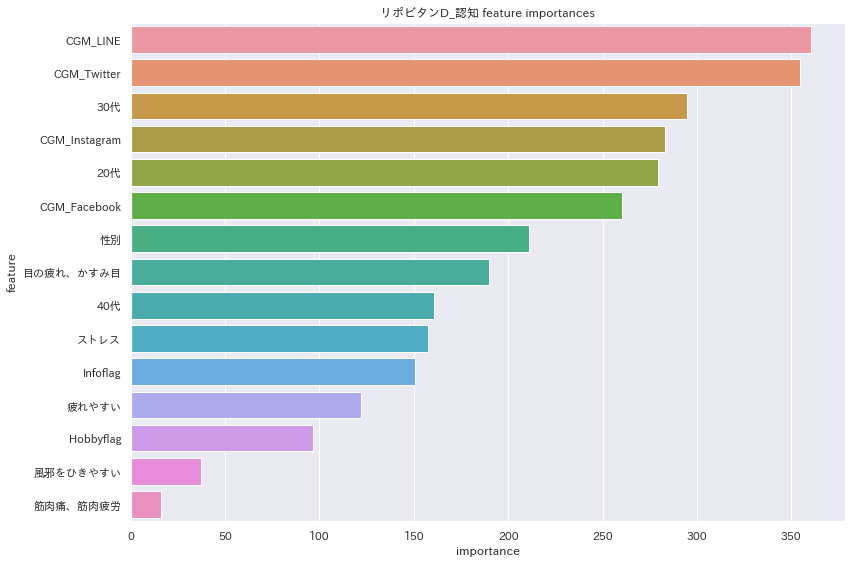

In [21]:
target = "リポビタンD_認知"
df_tmp = df[cols]
target_y = df[target]
get_importance(df_tmp,target_y,target)
del target,df_tmp,target_y

========== レッドブル_認知 ===============
========== fold : 1 ===============
Score : 0.9753086419753086


========== fold : 2 ===============
Score : 0.9717813051146384


========== fold : 3 ===============
Score : 0.9752650176678446


========== fold : 4 ===============
Score : 0.9717314487632509


========== fold : 5 ===============
Score : 0.9734982332155477


Mean Score : 0.9735169293473179


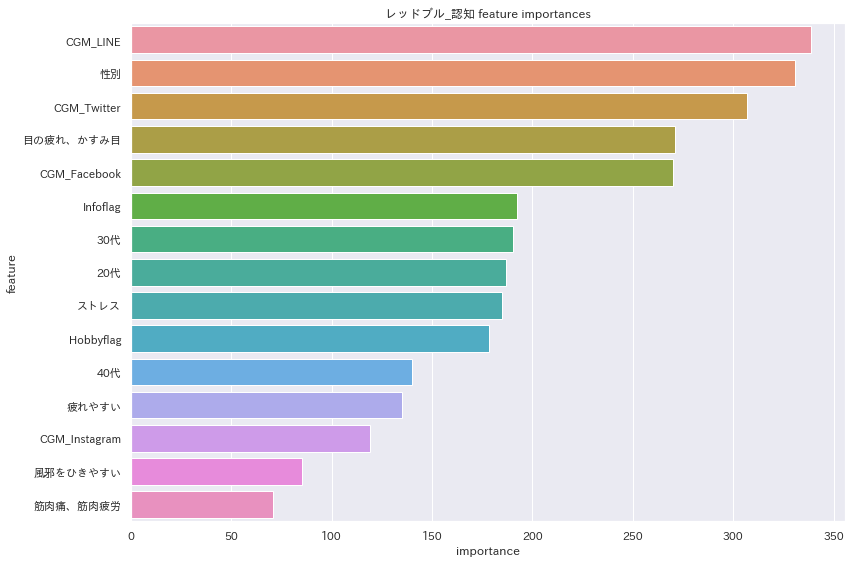

In [22]:
target = "レッドブル_認知"
df_tmp = df[cols]
target_y = df[target]
get_importance(df_tmp,target_y,target)
del target,df_tmp,target_y

========== オルナミンC_購買 ===============
========== fold : 1 ===============
Score : 0.8095238095238095


========== fold : 2 ===============
Score : 0.8342151675485009


========== fold : 3 ===============
Score : 0.8109540636042403


========== fold : 4 ===============
Score : 0.8144876325088339


========== fold : 5 ===============
Score : 0.8197879858657244


Mean Score : 0.8177937318102219


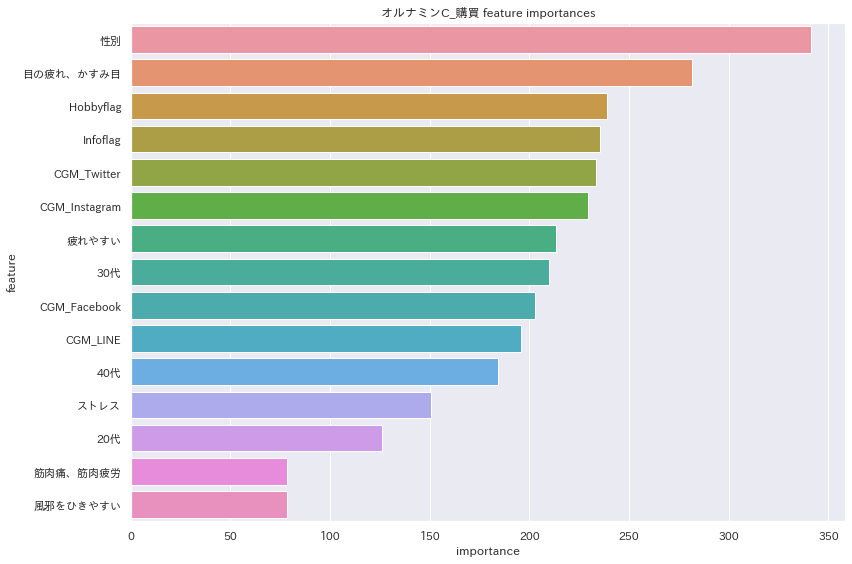

In [23]:
target = "オルナミンC_購買"
df_tmp = df[cols]
target_y = df[target]
get_importance(df_tmp,target_y,target)
del target,df_tmp,target_y

========== タフマン_購買 ===============
========== fold : 1 ===============
Score : 0.8977072310405644


========== fold : 2 ===============
Score : 0.9241622574955908


========== fold : 3 ===============
Score : 0.9187279151943463


========== fold : 4 ===============
Score : 0.9169611307420494


========== fold : 5 ===============
Score : 0.9169611307420494


Mean Score : 0.9149039330429201


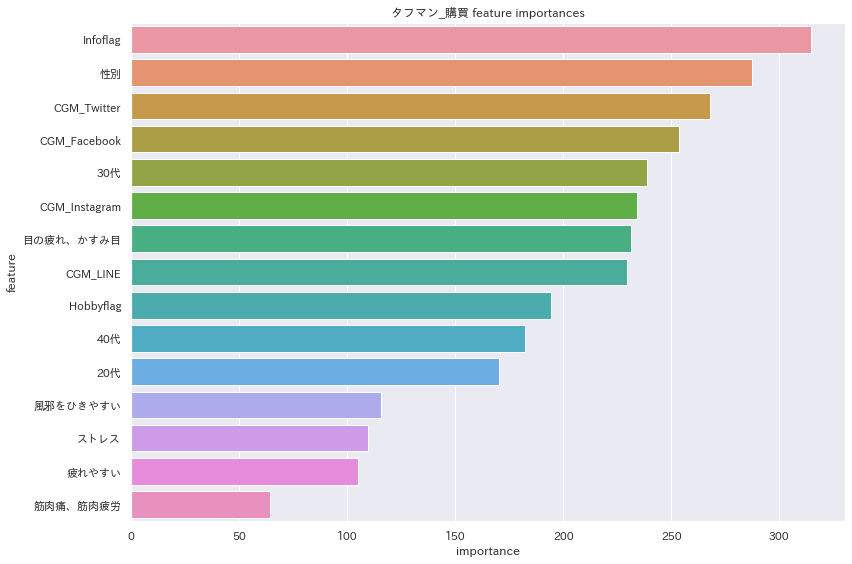

In [24]:
target = "タフマン_購買"
df_tmp = df[cols]
target_y = df[target]
get_importance(df_tmp,target_y,target)
del target,df_tmp,target_y

========== リポビタンD_購買 ===============
========== fold : 1 ===============
Score : 0.7883597883597884


========== fold : 2 ===============
Score : 0.8218694885361552


========== fold : 3 ===============
Score : 0.8127208480565371


========== fold : 4 ===============
Score : 0.7985865724381626


========== fold : 5 ===============
Score : 0.803886925795053


Mean Score : 0.8050847246371392


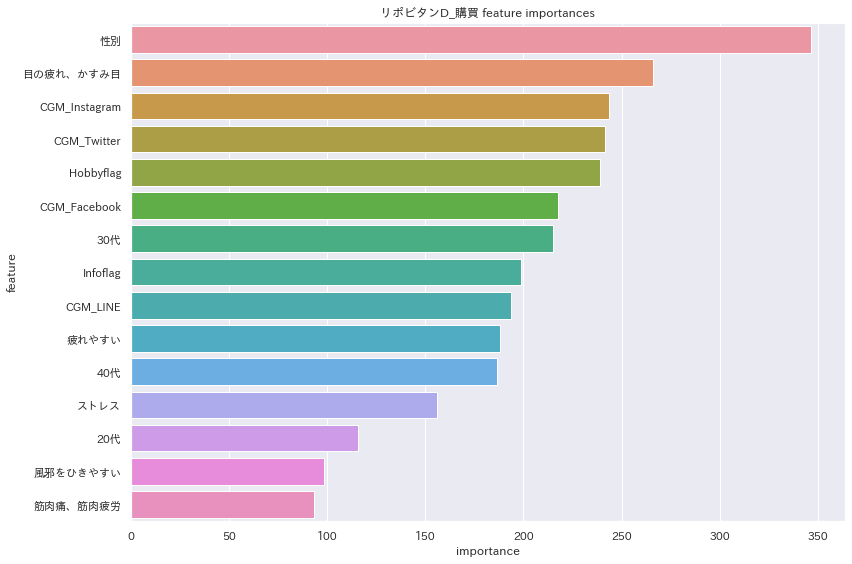

In [25]:
target = "リポビタンD_購買"
df_tmp = df[cols]
target_y = df[target]
get_importance(df_tmp,target_y,target)
del target,df_tmp,target_y

========== レッドブル_購買 ===============
========== fold : 1 ===============
Score : 0.8289241622574955


========== fold : 2 ===============
Score : 0.8500881834215167


========== fold : 3 ===============
Score : 0.8144876325088339


========== fold : 4 ===============
Score : 0.823321554770318


========== fold : 5 ===============
Score : 0.8515901060070671


Mean Score : 0.8336823277930463


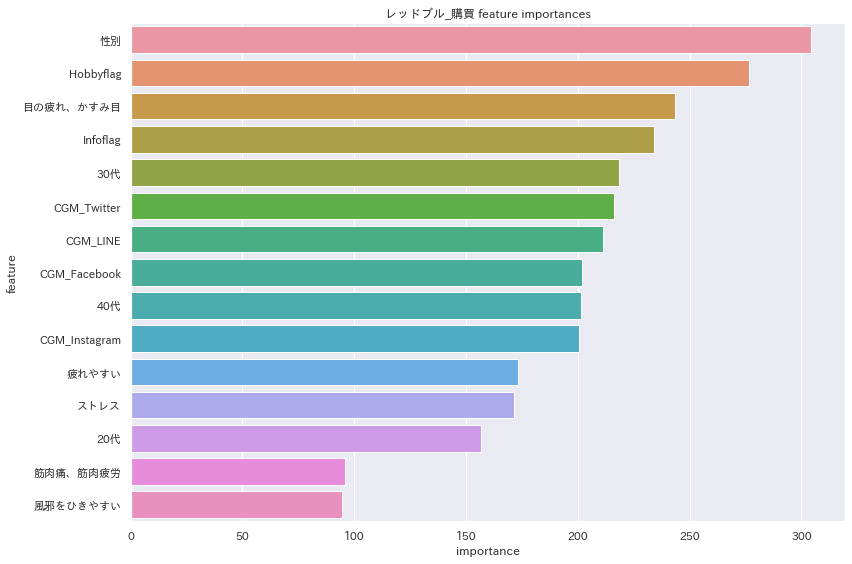

In [26]:
target = "レッドブル_購買"
df_tmp = df[cols]
target_y = df[target]
get_importance(df_tmp,target_y,target)
del target,df_tmp,target_y

In [20]:
# ===============================================================================
# やってないこと
# GBDTのパラメータ調整
# SHAPを使って0,1にどういう人が分類される可能性が高いのかや
# Skaterを使った決定木代理モデルをみるのも面白いかも 
# (余力がありませんでした🙇)
# ===============================================================================

In [21]:
# ===============================================================================================
# このノートでは2017年度の法政大学のデータに沿って行ったが,Treemodelを用いるなら
# あまり前処理をせずにいろんな変数を入れてImportanceを見るのも面白いかも(機械の力技で芸がない？)
# ===============================================================================================